# 方法二：使用ArcGIS Pro寻找街景点
[获取数据集——《通过深度学习了解建筑年代和风格》论文复现（二）](https://cdn.renhai-lab.tech/archives/Understanding_architecture_age_and_style_through_deep_learning_part2)

## 分步骤解释：

### 1.简化建筑物
https://pro.arcgis.com/zh-cn/pro-app/3.0/tool-reference/cartography/simplify-building.htm

![示意图](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202310170935112.png)

代码：'arcpy.cartography.SimplifyBuilding(in_features, out_feature_class, simplification_tolerance, {minimum_area}, {conflict_option}, {in_barriers}, {collapsed_point_option})'

In [44]:
arcpy.cartography.SimplifyBuilding("Amsterdam_buil_0363100012061237", 
                                   "single_building_SimplifyBuild", 
                                   "3 Meters", None, "NO_CHECK", None, "NO_KEEP")

<Result 'C:\\Users\\hncdj\\Documents\\Python_\\Python辅助城市研究\\建筑风格和年代机器学习\\5-ArcgisPro工程\\建筑风格和年代深度学习.gdb\\single_building_SimplifyBuild'>

### 2.获取建筑物的边上的中点

In [45]:
import arcpy

# 输入的多边形要素类
input_polygon_feature_class = "single_building_SimplifyBuild" # "single_building" # "Amsterdam_buildings_Project"


In [46]:
# 定义SpatialReference对象，这里以WGS 1984坐标系为例
sr = arcpy.SpatialReference(32631)

# 使用SearchCursor遍历多边形
with arcpy.da.SearchCursor(input_polygon_feature_class, ["identificatie", "SHAPE@"]) as cursor:
    for row in cursor:

        polygon_id = row[0] # 建筑的id
        polygon = row[1]
        
        
        # 创建一个Array
        point_array = arcpy.Array()
        
        # 遍历多边形的每一段，计算并存储中心点
        # 遍历poly中所有的多边形，part为每个单独的多边形
        for part in polygon: 
            # 遍历每个边
            for i in range(len(part) - 1):
                start_point = part[i]
                end_point = part[i + 1]
                mid_x = (start_point.X + end_point.X) / 2
                mid_y = (start_point.Y + end_point.Y) / 2
                print(mid_x, mid_y)
                
                # 创建arcpy的点
                midpoint = arcpy.Point(mid_x, mid_y)
                
                # 添加到Array
                point_array.add(midpoint)
                
            # 使用Array创建Multipoint对象
            multipoint = arcpy.Multipoint(point_array, sr)


626666.8219000003 5799563.76475
626661.8779500001 5799559.9069
626656.6625000001 5799565.5102
626663.25 5799571.4521
626670.24835 5799569.61565
626668.6048000003 5799567.5316


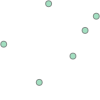

In [47]:
multipoint

In [48]:
# 保存Multipoint对象
arcpy.CopyFeatures_management(multipoint, "multipoint")

<Result 'C:\\Users\\hncdj\\Documents\\Python_\\Python辅助城市研究\\建筑风格和年代机器学习\\5-ArcgisPro工程\\建筑风格和年代深度学习.gdb\\multipoint'>

### 3.从每个点找到距离周围道路最近的点Point C，以及Point S，heading值

In [49]:
mid_x, mid_y

(626668.6048000003, 5799567.5316)

In [50]:
# 邻近分析 (分析)
in_features = "multipoint"
near_features = "main.edges"
search_radius = "25 Meters"
arcpy.analysis.Near(in_features, 
                    near_features, 
                    "25 Meters", "LOCATION", "ANGLE", "PLANAR", "NEAR_FID NEAR_FID;NEAR_DIST NEAR_DIST;NEAR_X NEAR_X;NEAR_Y NEAR_Y;NEAR_ANGLE NEAR_ANGLE")

<Result 'multipoint'>

In [51]:
in_features

'multipoint'

In [52]:
fields = arcpy.ListFields(in_features)
for field in fields:
    print(field.name)

OBJECTID
Shape
NEAR_FID
NEAR_DIST
NEAR_X
NEAR_Y
NEAR_ANGLE


### 4.将angle转为heading的角度
生成的角度是输入要素（建筑物上的点）对于邻近要素（街道上的点）的角度，并且转换前的角度的表示方式是：在方法参数中使用平面方法时，角度在 -180° 到 180° 的范围内，0°代表东，90°代表北，180°（或 -180°）代表西，-90° 代表南。
转换后，因为要获取街道街景，要以（街道上的点）为原点，对于建筑物上的点的角度，并且角度表示为：角度范围在0-360度，0°代表北，90°代表东，180°代表南，270° 代表西。

In [53]:
# def transform_angle(xs, ys, xc, yc):
#     """
#     方式一：计算向量转换角度的表示方式，从输入要素（建筑物上的点）对于邻近要素（街道上的点）的角度，
#     到以邻近要素（街道上的点）为原点，对于输入要素（建筑物上的点）的角度。
#     并确保角度在0-360度之间。
#     """
#     # 计算向量
#     Vsc = np.array([xc - xs, yc - ys])
#     
#     # 计算与正东方向的角度（由于数学上的约定，这里的0°是指向东的）
#     angle_rad = np.arctan2(Vsc[1], Vsc[0])  # 这里得到的结果范围是 -π 到 π (-180° 到 180°)
# 
#     # 将弧度转换为角度
#     angle_deg = np.degrees(angle_rad)
#     
#     # 转换为罗盘式角度（北0°，东90°...）
#     # 由于原始0°指向东，我们需要将角度逆时针旋转90°来让0°指向北
#     compass_angle = (90 - angle_deg) % 360  # 通过取余数确保结果在0° - 360°范围内
# 
#     return compass_angle
# 
# print( transform_angle(xs, ys, xc, yc))

In [59]:
def transform_angle(original_angle):
    """
    将角度从一个坐标系转换为另一个，并更改方向表示。

    :param original_angle: 初始的角度（基于东为0°的系统）
    :return: 转换后的角度（基于北为0°的系统）
    """
    # 从建筑物到街道的角度需要将角度旋转180度以“反转”方向
    reversed_angle = original_angle + 180

    # 规范化角度在0到360之间
    if reversed_angle >= 360:
        reversed_angle -= 360
    elif reversed_angle < 0:
        reversed_angle += 360

    # 现在，我们需要将“东为0度”转变为“北为0度”，这需要一个90度的逆时针旋转
    north_based_angle = reversed_angle + 90

    if north_based_angle >= 360:
        north_based_angle -= 360

    return north_based_angle

print(transform_angle(-178.9227630675157))

91.07723693248431


In [60]:
# 定义要查询的字段
field_name_list = ["NEAR_DIST","NEAR_X","NEAR_Y", "NEAR_ANGLE"]


# 使用SearchCursor迭代访问每个记录
with arcpy.da.SearchCursor(in_features, field_name_list) as cursor:
    for row in cursor:
        # 获取NEAR_ANGLE字段的值并添加到列表中
        print([i for i in row])
        angle = row[3]
        angle2 = transform_angle(angle)
        print("转换后的角度",angle2)

# 打印所有的NEAR_ANGLE值
print("当前建筑的id", polygon_id)

[15.729911607404052, 626640.935368494, 5799565.214474143, -178.9227630675157]
转换后的角度 91.07723693248431
当前建筑的id 0363100012061237


In [61]:
# 追加保存到json文件，然后通过streetview进行构建url的操作
import pandas as pd

# 从字典创建 DataFrame
df = pd.DataFrame({
    "polygon_id": [polygon_id],  
    "NEAR_DIST": [row[0]],      
    "lat": [row[2]],            
    "lng": [row[1]],
    "heading": [angle]
})


# 追加数据到 CSV
df.to_csv("./temp.csv", mode='a', header=False, index=False)


In [ ]:
# # 将heading（NEAR_ANGLE）,经纬度，保存到input_polygon_feature_class：single_building
# with arcpy.da.UpdateCursor(input_polygon_feature_class, ["identificatie","SHAPE@",]) as cursor:
#     for row in cursor:
#         # 对每一行进行某种操作...
        
#         # 示例：修改 'identificatie' 字段的值
#         row[1] = "新的值"  # 更新 'identificatie' 到新的值
        
#         # 保存更改
#         cursor.updateRow(row)


## 整合上述代码：遍历building然后查询临近点

In [65]:
import arcpy
import pandas as pd
# 输入的多边形要素类
input_polygon_feature_class = "Amsterdam_buil_ExportFeature1_98" # "single_building" # "Amsterdam_buildings_Project"


# 整合代码
# 定义SpatialReference对象，这里以WGS 1984坐标系为例
sr = arcpy.SpatialReference(32631)


def field_exists(feature_class, field_name):
    """检查给定的字段是否存在于指定的要素类中"""
    fields = [f.name for f in arcpy.ListFields(feature_class)]
    return field_name in fields

 def transform_angle(original_angle):
    """
    将角度从一个坐标系转换为另一个，并更改方向表示。

    :param original_angle: 初始的角度（基于东为0°的系统）
    :return: 转换后的角度（基于北为0°的系统）
    """
    # 从建筑物到街道的角度需要将角度旋转180度以“反转”方向
    reversed_angle = original_angle + 180

    # 规范化角度在0到360之间
    if reversed_angle >= 360:
        reversed_angle -= 360
    elif reversed_angle < 0:
        reversed_angle += 360

    # 现在，我们需要将“东为0度”转变为“北为0度”，这需要一个90度的逆时针旋转
    north_based_angle = reversed_angle + 90

    if north_based_angle >= 360:
        north_based_angle -= 360

    return north_based_angle

# 定义要查询的字段
field_name_list =  ["NEAR_DIST","NEAR_X","NEAR_Y", "NEAR_ANGLE"]

# 用于检查邻域分析是否成功
field_to_check = field_name_list[0]

# 使用SearchCursor遍历多边形
with arcpy.da.SearchCursor(input_polygon_feature_class, ["identificatie", "SHAPE@"]) as cursor:
    for row in cursor:
        polygon_id = row[0] # 建筑的id
        polygon = row[1]
        
        # 创建一个Array
        point_array = arcpy.Array()
        
        # 遍历多边形的每一段，计算并存储中心点
        # 遍历poly中所有的多边形，part为每个单独的多边形
        for part in polygon: 
            # 遍历每个边
            for i in range(len(part) - 1):
                start_point = part[i]
                end_point = part[i + 1]
                mid_x = (start_point.X + end_point.X) / 2
                mid_y = (start_point.Y + end_point.Y) / 2
                # print(mid_x, mid_y)
                
                # 创建arcpy的点
                midpoint = arcpy.Point(mid_x, mid_y)
                
                # 添加到Array
                point_array.add(midpoint)
                
            # 使用Array创建Multipoint对象
            multipoint = arcpy.Multipoint(point_array, sr)

            arcpy.CopyFeatures_management(multipoint, "multipoint")
            
            # 邻近分析 (分析)
            in_features = "multipoint"
            near_features = "main.edges"
            arcpy.analysis.Near(in_features, 
                                near_features, 
                                "25 Meters", "LOCATION", "ANGLE", "GEODESIC", "NEAR_FID NEAR_FID;NEAR_DIST NEAR_DIST;NEAR_X NEAR_X;NEAR_Y NEAR_Y;NEAR_ANGLE NEAR_ANGLE")
            
            
            if field_exists(in_features, field_to_check):
                # 使用SearchCursor迭代访问每个记录
                with arcpy.da.SearchCursor(in_features, field_name_list) as cursor:
                    for row in cursor:
                        # 删除NEAR_DIST=-1的数据
                        NEAR_DIST = row[0]

                        
                        angle = transform_angle(row[3])

                        # 打印所有的NEAR_ANGLE值
                        print("当前建筑的id", polygon_id)


                # 保存
                if NEAR_DIST !=-1:
                
                    # 从字典创建 DataFrame
                    df = pd.DataFrame({
                        "polygon_id": [polygon_id],  
                        "NEAR_DIST": [row[0]],      
                        "lat": [row[2]],            
                        "lng": [row[1]],
                        "heading": [angle]
                    })


                    # 追加数据到 CSV
                    df.to_csv("./temp.csv", mode='a', header=False, index=False)


            else:
                print(f"Field '{field_to_check}' does not exist in {in_features}.")



IndentationError: unindent does not match any outer indentation level (<tokenize>, line 17)

## 优化代码逻辑(从这开始时正式执行代码)
为了提高上述代码的执行速度，我们可以考虑以下策略：
减少I/O操作: 代码中有多次磁盘I/O操作，特别是与arcpy和pandas相关的部分。I/O操作通常是时间消耗的关键所在。
使用多线程/多进程: 但需要注意的是**arcpy不是线程安全的，所以多线程可能并不总是有效。**另外，你的代码涉及到GIS数据的写入，这也可能导致多线程中出现资源争用的问题。
我们可以创建一个列表来存储数据，而不是每次都将其追加到CSV。在整个循环完成后，我们再保存这个列表到CSV。